# Big Mart Sales Data Analysis

## 1. Preprocessing

### 1.1. Import modules

In [136]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import itertools as it
import warnings

from sklearn.linear_model import LinearRegression, Ridge,Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
from sklearn import metrics

%matplotlib inline

warnings.filterwarnings("ignore")
rng = np.random.default_rng()

plt.close("all")

In [176]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col,isnan, when, count,substring, log, col
from pyspark.ml.feature import Imputer

spark=SparkSession.builder.appName('BigMartSales').getOrCreate()
spark

### 1.2. Data import

In [138]:
## read the dataset
df=spark.read.option('header','true').csv(r"Train-Set.csv",inferSchema=True)

## 1.3. Exploratory Analysis

### 1.3.1. Context

The data scientists at Big Mart have collected 2013 sales data for 1559 products across 10 stores in different cities. Also, certain attributes of each product and store have been defined. The aim is to build a predictive model and predict the sales of each product at a particular outlet.

Using this model, Big Mart will try to understand the properties of products and outlets which play a key role in increasing sales.

Please note that the data may have missing values as some stores might not report all the data due to technical glitches. Hence, it will be required to treat them accordingly.

### 1.3.2. Variable description

As we can see in the dataframes below, there are 11 columns in each subset plus 1 column with outlet sales in the df set. 

- **ProductID** : unique product ID
- **Weight** : weight of products
- **FatContent** : specifies whether the product is low on fat or not
- **Visibility** : percentage of total display area of all products in a store allocated to the particular product
- **ProductType** : the category to which the product belongs
- **MRP** : Maximum Retail Price (listed price) of the products
- **OutletID** : unique store ID
- **EstablishmentYear** : year of establishment of the outlets
- **OutletSize** : the size of the store in terms of ground area covered
- **LocationType** : the type of city in which the store is located
- **OutletType** : specifies whether the outlet is just a grocery store or some sort of supermarket
- **OutletSales** : (target variable) sales of the product in the particular store

In [139]:
df.printSchema()


root
 |-- ProductID: string (nullable = true)
 |-- Weight: double (nullable = true)
 |-- FatContent: string (nullable = true)
 |-- ProductVisibility: double (nullable = true)
 |-- ProductType: string (nullable = true)
 |-- MRP: double (nullable = true)
 |-- OutletID: string (nullable = true)
 |-- EstablishmentYear: integer (nullable = true)
 |-- OutletSize: string (nullable = true)
 |-- LocationType: string (nullable = true)
 |-- OutletType: string (nullable = true)
 |-- OutletSales: double (nullable = true)



In [140]:
df.show(5)

+---------+------+----------+-----------------+--------------------+--------+--------+-----------------+----------+------------+-----------------+-----------+
|ProductID|Weight|FatContent|ProductVisibility|         ProductType|     MRP|OutletID|EstablishmentYear|OutletSize|LocationType|       OutletType|OutletSales|
+---------+------+----------+-----------------+--------------------+--------+--------+-----------------+----------+------------+-----------------+-----------+
|    FDA15|   9.3|   Low Fat|      0.016047301|               Dairy|249.8092|  OUT049|             1999|    Medium|      Tier 1|Supermarket Type1|   3735.138|
|    DRC01|  5.92|   Regular|      0.019278216|         Soft Drinks| 48.2692|  OUT018|             2009|    Medium|      Tier 3|Supermarket Type2|   443.4228|
|    FDN15|  17.5|   Low Fat|      0.016760075|                Meat| 141.618|  OUT049|             1999|    Medium|      Tier 1|Supermarket Type1|    2097.27|
|    FDX07|  19.2|   Regular|              0.0

Data types are mostly of type "object" while all of them are in fact of type "category" (ProductID, FatContent, ProductType, OutletID, OutletSize, LocationType and OutletType). Therefore, in later on the data type will be changed.

In [141]:
# check unique values in dataset
# df.apply(lambda x: len(x.unique()))


In [142]:

df.show(5)

+---------+------+----------+-----------------+--------------------+--------+--------+-----------------+----------+------------+-----------------+-----------+
|ProductID|Weight|FatContent|ProductVisibility|         ProductType|     MRP|OutletID|EstablishmentYear|OutletSize|LocationType|       OutletType|OutletSales|
+---------+------+----------+-----------------+--------------------+--------+--------+-----------------+----------+------------+-----------------+-----------+
|    FDA15|   9.3|   Low Fat|      0.016047301|               Dairy|249.8092|  OUT049|             1999|    Medium|      Tier 1|Supermarket Type1|   3735.138|
|    DRC01|  5.92|   Regular|      0.019278216|         Soft Drinks| 48.2692|  OUT018|             2009|    Medium|      Tier 3|Supermarket Type2|   443.4228|
|    FDN15|  17.5|   Low Fat|      0.016760075|                Meat| 141.618|  OUT049|             1999|    Medium|      Tier 1|Supermarket Type1|    2097.27|
|    FDX07|  19.2|   Regular|              0.0

### 1.3.1. Missing data imputation

In [143]:
# check null values
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+---------+------+----------+-----------------+-----------+---+--------+-----------------+----------+------------+----------+-----------+
|ProductID|Weight|FatContent|ProductVisibility|ProductType|MRP|OutletID|EstablishmentYear|OutletSize|LocationType|OutletType|OutletSales|
+---------+------+----------+-----------------+-----------+---+--------+-----------------+----------+------------+----------+-----------+
|        0|  1463|         0|                0|          0|  0|       0|                0|      2410|           0|         0|          0|
+---------+------+----------+-----------------+-----------+---+--------+-----------------+----------+------------+----------+-----------+



As can be seen in the tables above, there is a significat amount of missing data in both subsets. Therefore a missing data imputation is recommended and will be performed. As an imputation algorithm, prediction of missing values will be used, namely linear regression for **Weight** and multinomial logistic regression for **OutletSize**.

In [144]:
# fill the missing values in categorical variables
item_weight_mean = df.select(["Weight", "ProductID"]).groupBy('ProductID').mean()
item_weight_mean.show()

+---------+------------------+
|ProductID|       avg(Weight)|
+---------+------------------+
|    FDB11|              16.0|
|    FDO11|               8.0|
|    DRA24|             19.35|
|    FDU24|              6.78|
|    FDW60|              5.44|
|    FDW52|              14.0|
|    FDN15|              17.5|
|    FDQ20|             8.325|
|    FDU10|              10.1|
|    FDY43|             14.85|
|    NCL54|              12.6|
|    FDP39|             12.65|
|    NCN30|             16.35|
|    NCS30|             5.945|
|    NCW05|             20.25|
|    NCF42|17.349999999999998|
|    FDX27|              20.7|
|    FDD20|             14.15|
|    FDW32|18.349999999999998|
|    NCW18|              15.1|
+---------+------------------+
only showing top 20 rows



In [145]:
# missing data imputation with mean
mean_imputer = Imputer(strategy='mean')
mean_imputer.setInputCols(['Weight'])
mean_imputer.setOutputCols(["Weight"])
model = mean_imputer.fit(df)

In [146]:
model.surrogateDF.show()

+------------------+
|            Weight|
+------------------+
|12.857645184136183|
+------------------+



In [147]:
df=model.transform(df)
df.show()

+---------+------------------+----------+-----------------+--------------------+--------+--------+-----------------+----------+------------+-----------------+-----------+
|ProductID|            Weight|FatContent|ProductVisibility|         ProductType|     MRP|OutletID|EstablishmentYear|OutletSize|LocationType|       OutletType|OutletSales|
+---------+------------------+----------+-----------------+--------------------+--------+--------+-----------------+----------+------------+-----------------+-----------+
|    FDA15|               9.3|   Low Fat|      0.016047301|               Dairy|249.8092|  OUT049|             1999|    Medium|      Tier 1|Supermarket Type1|   3735.138|
|    DRC01|              5.92|   Regular|      0.019278216|         Soft Drinks| 48.2692|  OUT018|             2009|    Medium|      Tier 3|Supermarket Type2|   443.4228|
|    FDN15|              17.5|   Low Fat|      0.016760075|                Meat| 141.618|  OUT049|             1999|    Medium|      Tier 1|Super

In [148]:
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+---------+------+----------+-----------------+-----------+---+--------+-----------------+----------+------------+----------+-----------+
|ProductID|Weight|FatContent|ProductVisibility|ProductType|MRP|OutletID|EstablishmentYear|OutletSize|LocationType|OutletType|OutletSales|
+---------+------+----------+-----------------+-----------+---+--------+-----------------+----------+------------+----------+-----------+
|        0|     0|         0|                0|          0|  0|       0|                0|      2410|           0|         0|          0|
+---------+------+----------+-----------------+-----------+---+--------+-----------------+----------+------------+----------+-----------+



In [149]:
df = df.fillna("Medium")
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+---------+------+----------+-----------------+-----------+---+--------+-----------------+----------+------------+----------+-----------+
|ProductID|Weight|FatContent|ProductVisibility|ProductType|MRP|OutletID|EstablishmentYear|OutletSize|LocationType|OutletType|OutletSales|
+---------+------+----------+-----------------+-----------+---+--------+-----------------+----------+------------+----------+-----------+
|        0|     0|         0|                0|          0|  0|       0|                0|         0|           0|         0|          0|
+---------+------+----------+-----------------+-----------+---+--------+-----------------+----------+------------+----------+-----------+



## 2. Exploratory analysis
### 2.1. Categorical variables

<AxesSubplot: >

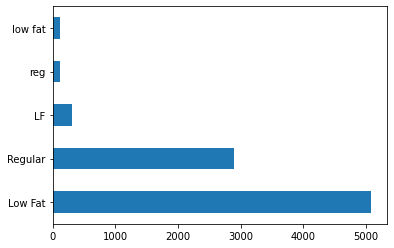

In [150]:
df.toPandas()["FatContent"].value_counts().plot(kind="barh")

<AxesSubplot: >

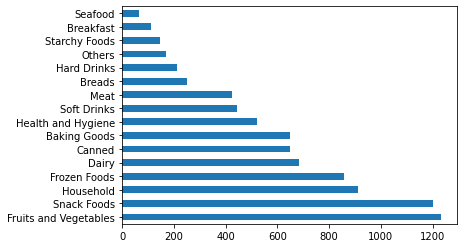

In [151]:
df.toPandas()["ProductType"].value_counts().plot(kind="barh")

<AxesSubplot: >

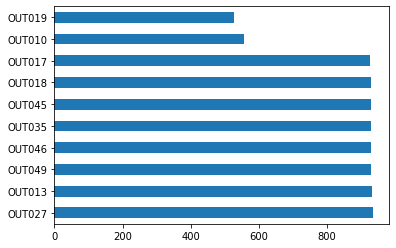

In [152]:
df.toPandas()["OutletID"].value_counts().plot(kind="barh")

<AxesSubplot: >

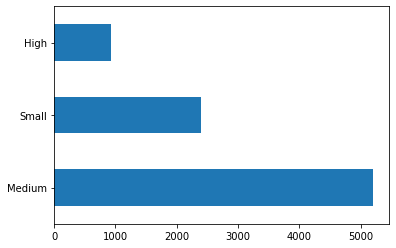

In [153]:
df.toPandas()["OutletSize"].value_counts().plot(kind="barh")

<AxesSubplot: >

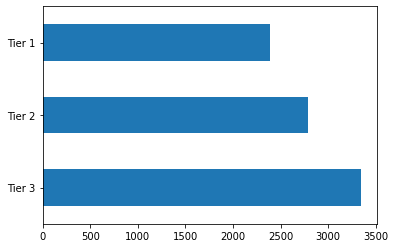

In [154]:
df.toPandas()["LocationType"].value_counts().plot(kind="barh")

<AxesSubplot: >

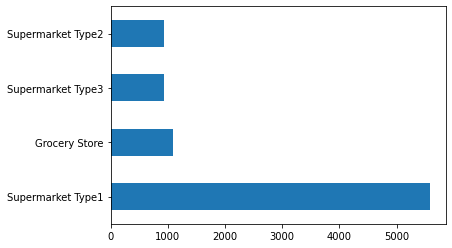

In [155]:
df.toPandas()["OutletType"].value_counts().plot(kind="barh")

<AxesSubplot: >

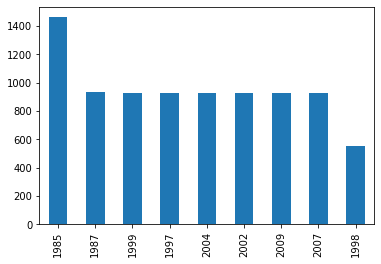

In [156]:
df.toPandas()["EstablishmentYear"].value_counts().plot(kind="bar")

You can see in the plots, that some of the variables have more category levels than needed (some levels overlap): **FatContent** has 5 categories in the dataset, but in fact there are only 2. Levels *low fat*, *Low Fat* and *LF* will be joined into one category *Low Fat*. Accordingly, *reg* and *Regular* levels will be joined into *Regular*. Variable **OutletSize** should be ordered, because *High* > *Medium* > *Small*. Also *EstablishmentYear* levels will be sorted.

In [157]:
# joining categories
df = df.withColumn("FatContent", when(df.FatContent == "low fat", "Low Fat").otherwise(df.FatContent))
df = df.withColumn("FatContent", when(df.FatContent == "LF", "Low Fat").otherwise(df.FatContent))
df = df.withColumn("FatContent", when(df.FatContent == "reg", "Regular").otherwise(df.FatContent))

# setting proper category levels
# df["FatContent"] = df["FatContent"].astype(
#     pd.CategoricalDtype(categories=["Low Fat", "Regular"], ordered=False)
# )

In [158]:
df.select("FatContent").show()

+----------+
|FatContent|
+----------+
|   Low Fat|
|   Regular|
|   Low Fat|
|   Regular|
|   Low Fat|
|   Regular|
|   Regular|
|   Low Fat|
|   Regular|
|   Regular|
|   Low Fat|
|   Regular|
|   Regular|
|   Regular|
|   Low Fat|
|   Regular|
|   Low Fat|
|   Regular|
|   Low Fat|
|   Low Fat|
+----------+
only showing top 20 rows



In [159]:
# # reordering levels
# df["OutletSize"] = df["OutletSize"].astype(
#     pd.CategoricalDtype(categories=["Small", "Medium", "High"], ordered=True)
# )

# changing establishment year into years from establichement date
df = df.withColumn("OutletYears", 2013 - df.EstablishmentYear)

In [160]:
df.show(5)

+---------+------+----------+-----------------+--------------------+--------+--------+-----------------+----------+------------+-----------------+-----------+-----------+
|ProductID|Weight|FatContent|ProductVisibility|         ProductType|     MRP|OutletID|EstablishmentYear|OutletSize|LocationType|       OutletType|OutletSales|OutletYears|
+---------+------+----------+-----------------+--------------------+--------+--------+-----------------+----------+------------+-----------------+-----------+-----------+
|    FDA15|   9.3|   Low Fat|      0.016047301|               Dairy|249.8092|  OUT049|             1999|    Medium|      Tier 1|Supermarket Type1|   3735.138|         14|
|    DRC01|  5.92|   Regular|      0.019278216|         Soft Drinks| 48.2692|  OUT018|             2009|    Medium|      Tier 3|Supermarket Type2|   443.4228|          4|
|    FDN15|  17.5|   Low Fat|      0.016760075|                Meat| 141.618|  OUT049|             1999|    Medium|      Tier 1|Supermarket Type1

In [161]:
# create new category for NewProductType
df = df.withColumn("NewProductType", substring(df.ProductID, 0,2))
df.select('NewProductType').show()

+--------------+
|NewProductType|
+--------------+
|            FD|
|            DR|
|            FD|
|            FD|
|            NC|
|            FD|
|            FD|
|            FD|
|            FD|
|            FD|
|            FD|
|            FD|
|            FD|
|            FD|
|            FD|
|            FD|
|            NC|
|            FD|
|            DR|
|            FD|
+--------------+
only showing top 20 rows



In [162]:
df = df.withColumn("NewProductType",  when(df.NewProductType == "DR", "Drinks").otherwise(df.NewProductType))
df = df.withColumn("NewProductType",  when(df.NewProductType == "NC", "Non-Consumable").otherwise(df.NewProductType))
df = df.withColumn("NewProductType",  when(df.NewProductType == "FD", "Food").otherwise(df.NewProductType))
df.groupBy("NewProductType").count().show()

+--------------+-----+
|NewProductType|count|
+--------------+-----+
|          Food| 6125|
|Non-Consumable| 1599|
|        Drinks|  799|
+--------------+-----+



In [163]:
df = df.withColumn("FatContent",  when(df.NewProductType == "Non-Consumable", "Non-Edible").otherwise(df.FatContent))
# df.loc[df['NewProductType']=='Non-Consumable', 'FatContent'] = 'Non-Edible'
# df['FatContent'].value_counts()
df.groupBy("FatContent").count().show()

+----------+-----+
|FatContent|count|
+----------+-----+
|   Low Fat| 3918|
|Non-Edible| 1599|
|   Regular| 3006|
+----------+-----+



<AxesSubplot: >

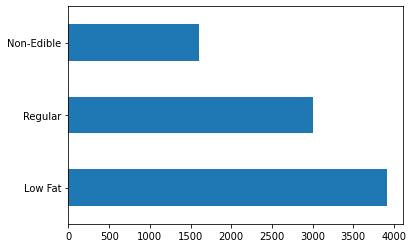

In [164]:
df.toPandas()["FatContent"].value_counts().plot(kind="barh")

<AxesSubplot: >

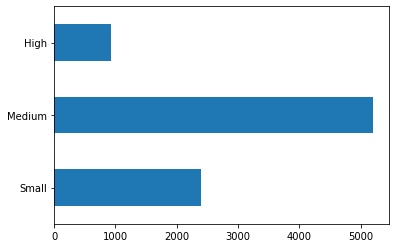

In [165]:
df.toPandas()["OutletSize"].value_counts().reindex(["Small", "Medium", "High"]).plot(kind="barh")

### 2.2. Continuous variables

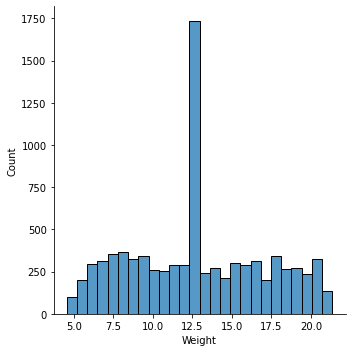

In [166]:
sns.displot(df.toPandas()['Weight'])

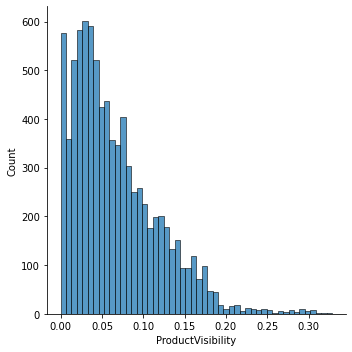

In [167]:
sns.displot(df.toPandas()['ProductVisibility'])

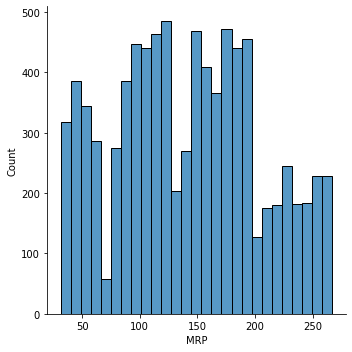

In [168]:
sns.displot(df.toPandas()['MRP'])

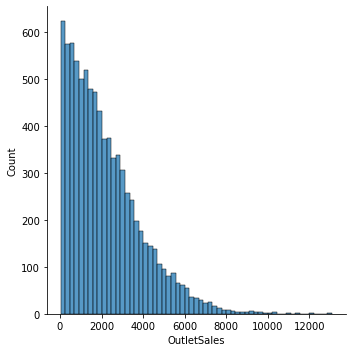

In [169]:
sns.displot(df.toPandas()['OutletSales'])

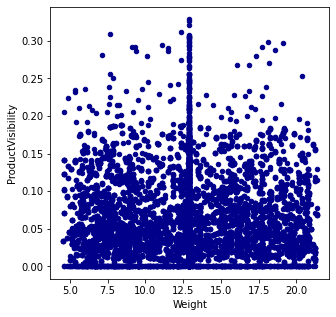

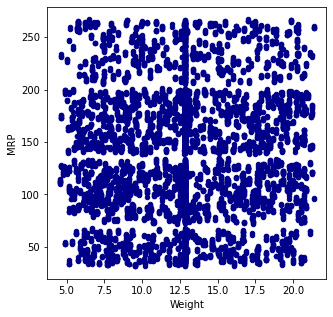

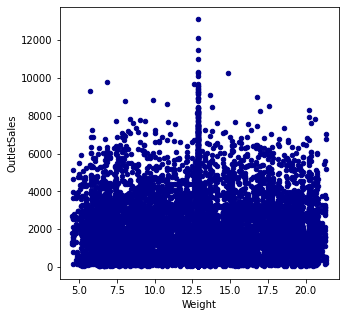

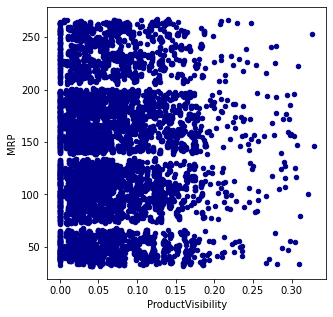

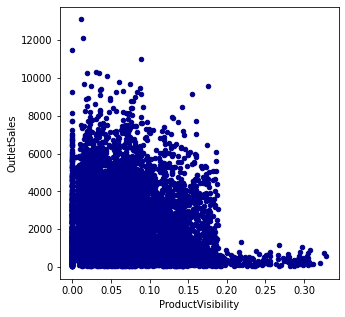

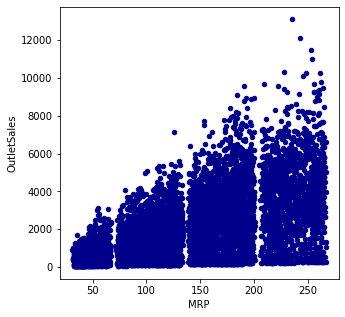

In [171]:
ContCols = df.toPandas().select_dtypes(include=["float64"])

for combination in it.combinations(ContCols, 2):
    df.toPandas().plot.scatter(
        x=combination[0],
        y=combination[1],
        color="DarkBlue",
        subplots=True,
        figsize=(5, 5),
    )

In the plots above we can see, that the continuous variables are probably not related to each other, maybe except for *OutletSales* and *ProductVisibility* as well as *OutletSales* and *MRP* - this is to be checked. Moreover, *ProductVisibility* and *OutletSales* are left-skewed and *MRP* and *Weight* seem to have normal distribution. Both suppositions will be checked in the next step. Also, *OutletSales* has pretty huge units in comparison to ll other continuous variables, therefore it will be logarithmized.

In [177]:
# log transformation
df = df.withColumn("OutletSales", log(col("OutletSales")))


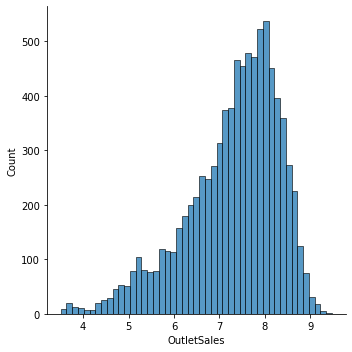

In [178]:
sns.displot(df.toPandas()['OutletSales'])

Now *OutletSales* seem to be right-skewed and has values closer to other continuous variables.

### 2.3. Analysis of correlation, co-linearity of variables etc.

#### 2.3.1. Correlation



<AxesSubplot: >

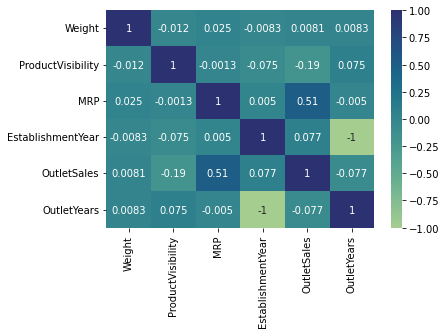

In [179]:
corr = df.toPandas().corr()
sns.heatmap(corr, annot=True, cmap='crest')

In the above plot we can see that *EstablishemntYear* and *OutletYears* are highly negative correlated, which is clear (*OutletYears* is a derivative of *EstablishemntYear*). *MRP* and *OutletSales* are mildly correlated which does not seem to affect the model too much.

### Variables encoding

In order to give correct variables to the model, we need to encode variables. *OutletID* and *ProductID* won't be encoded, because thay won't be included in the model.

In [ ]:
df.dtypes

In [ ]:
df = pd.get_dummies(df, columns = ['FatContent','OutletSize','LocationType','OutletType','NewProductType'])
df.show(5)

## 3. Main analysis of the data
 ### 3.1. Train-Test Split

In [ ]:
X=df.drop(columns=["EstablishmentYear", "OutletSales", "ProductID", "OutletID", "ProductType"], axis=1)
y=df["OutletSales"]

### 3.2. Model training

In [ ]:
def train(model, X, y):
    # train the model
    model.fit(X, y)

    # predict the training set
    pred = model.predict(X)

    # cross-validation
    cv_score = cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=10)
    cv_score = np.abs(np.mean(cv_score))

    # print model report
    print("Model Report")
    print("MAE:", metrics.mean_absolute_error(y, pred))
    print("MSE:", metrics.mean_squared_error(y, pred))
    print("RMSE:", np.sqrt(metrics.mean_squared_error(y, pred)))
    print("CV score:", cv_score)

#### 3.2.1. Linear Regression

In [ ]:
linear_model = LinearRegression(normalize=True)
train(linear_model, X, y)
linear_coef = pd.Series(linear_model.coef_, X.columns).sort_values()
linear_coef.plot(kind='bar', title="Model Coefficients")

#### 3.2.2. Ridge Regression

In [ ]:
ridge_model = Ridge(normalize=True)
train(ridge_model, X, y)
ridge_coef = pd.Series(ridge_model.coef_, X.columns).sort_values()
ridge_coef.plot(kind='bar', title="Model Coefficients")

#### 3.2.3. Lasso Regression

In [ ]:
lasso_model = Lasso()
train(lasso_model, X, y)
lasso_coef = pd.Series(lasso_model.coef_, X.columns).sort_values()
lasso_coef.plot(kind='bar', title="Model Coefficients")

#### 3.2.4. Regresion Tree

In [ ]:
tree_model = DecisionTreeRegressor()
train(tree_model, X, y)
tree_coef = pd.Series(tree_model.feature_importances_, X.columns).sort_values(ascending=False)
tree_coef.plot(kind='bar', title="Feature Importance")

As you can see the best scoring gained was for the plan Linear Regression model. Therefore, this model will be interpreted.

### 3.3. Model interpretation

In [ ]:
linear_coef